In [287]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from Scripts.dirty_accuracy import injection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

## Helper functions

Classifier functions

In [288]:
def GaussianClassification(X_train, y_train, X_test, y_test):
    clf = GaussianProcessClassifier()
    clf.fit(X_train, y_train)
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return [training_score, test_score]

In [289]:
def KNClassification(X_train, y_train, X_test, y_test):
    K = []
    training = []
    test = []
    scores = {}

    for k in range(1, 20):
        clf = KNeighborsClassifier(n_neighbors = k)
        clf.fit(X_train, y_train)

        training_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        K.append(k)

        training.append(training_score)
        test.append(test_score)
        scores[k] = [training_score, test_score]
    return [training[test.index(np.max(test))],np.max(test)]

Print scores

In [290]:
def printScores(scores):
    for score in scores:
        print("Dataset dirty at: ", score['dirty'], "%")
        print(score['scores'][0],':', score['scores'][1])

Plot scores

In [291]:
def plotScores(scores, title):
    sns.set_palette("PuBuGn_d")
    for score in scores:
        labels = list(score['scores'].keys())
        labels.insert(0,0)
        scoresDF = pd.DataFrame.from_dict(score['scores'], orient='index', columns=['Train '+str(score['dirty']), 'Test '+str(score['dirty'])])
        plot = sns.lineplot(data=scoresDF)
        plot.set_xticks(range(len(score['scores'])+1))
        plot.set_xticklabels(labels)
        plot.set_ylim(0.2,1.1)
        plot.set(xlabel ="N Neighbors", ylabel = "Performance", title =title)
        plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ZS Detection and correction

In [292]:
def ZS(data, threshold):
    mean = np.mean(data)
    sd = np.std(data)
    cleaned = []
    for i in data:
        z = (i - mean) / sd
        if abs(z) > threshold:
            cleaned.append(mean)
        else:
            cleaned.append(i)
    return cleaned

In [293]:
def DBSCANDetection(data):
    nbrs = NearestNeighbors(n_neighbors = 3)
    nbrs.fit(data)
    distances, indexes = nbrs.kneighbors(data)
    outlier_index = np.where(distances.mean(axis = 1) > 0.25)
    outlier_values = data.iloc[outlier_index]
    return  outlier_values

## Pipeline implementation

Read the dataset from CSV file
Drop the ID column

In [294]:
ecoli = pd.read_csv("datasets/ecoli.csv", sep=',')
ecoli = ecoli.drop('1', axis=1)

Perform the injections of outliers
and append the original clean dataset to the list

In [295]:
ecoli_list = injection(df_pandas=ecoli, seed=10, name='ecoli', name_class='class')
ecoli_list.append(ecoli)

saved ecoli-accuracy50%
saved ecoli-accuracy60%
saved ecoli-accuracy70%
saved ecoli-accuracy80%
saved ecoli-accuracy90%


Reverse the list on order to have
0 - Original Dataset
1 - 10% Dirty dataset
2 - 20% Dirty dataset
3 - 30% Dirty dataset
4 - 40% Dirty dataset
5 - 50% Dirty dataset

In [296]:
ecoli_list.reverse()

### Functions to be repeated for each dataframe

In [297]:
def computeScoresKN(dataframe_array):
    y = ecoli['class']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('class', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = KNClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [298]:
def computeScoresGC(dataframe_array):
    y = ecoli['class']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('class', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = GaussianClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [299]:
def cleanDatasetsZS(datasets):
    cleaned_list = []
    i = 6
    for df in datasets:
        cleaned = df.copy()
        for col in cleaned.columns:
            if col == 'class':
                continue
            cleaned[col] = ZS(cleaned[col].values, i/10)
        cleaned_list.append(cleaned)
        i = i-1
    return cleaned_list

### Performing KNeighbors Machine Learning classification
Dataset preparation

In [300]:
knscores = computeScoresKN(ecoli_list)
printScores(knscores)

Dataset dirty at:  0 %
0.8638297872340426 : 0.8613861386138614
Dataset dirty at:  10 %
0.6553191489361702 : 0.6435643564356436
Dataset dirty at:  20 %
0.5404255319148936 : 0.5346534653465347
Dataset dirty at:  30 %
0.4340425531914894 : 0.45544554455445546
Dataset dirty at:  40 %
0.43829787234042555 : 0.4752475247524752
Dataset dirty at:  50 %
0.44680851063829785 : 0.42574257425742573


In [301]:
gcscore = computeScoresGC(ecoli_list)
printScores(gcscore)

Dataset dirty at:  0 %
0.7659574468085106 : 0.7227722772277227
Dataset dirty at:  10 %
0.7829787234042553 : 0.45544554455445546
Dataset dirty at:  20 %
0.8851063829787233 : 0.37623762376237624
Dataset dirty at:  30 %
0.9531914893617022 : 0.36633663366336633
Dataset dirty at:  40 %
0.9744680851063829 : 0.26732673267326734
Dataset dirty at:  50 %
0.9957446808510638 : 0.26732673267326734


Find column by column outliers using ZS and replace them with mean value

In [312]:
cleaned_zs_lists = cleanDatasetsZS(ecoli_list)
cleaned_dbs_list = DBSCANDetection(ecoli_list[4].drop('class', axis=1))
cleaned_dbs_list

,2,3,4,5,6,7,8
0,0.490000,0.290000,0.480000,0.500000,8.353240,0.240000,-1.008519
1,0.070000,-5.068153,-1.627890,-1.150526,0.540000,0.350000,0.440000
2,0.560000,2.976665,2.518846,0.500000,-4.887905,-4.333742,0.460000
3,-0.186426,0.490000,0.480000,-3.346450,0.520000,4.077424,0.360000
4,0.230000,0.320000,0.480000,0.500000,0.550000,-8.779616,0.350000
...,...,...,...,...,...,...,...
331,0.740000,0.560000,0.480000,0.500000,9.054463,9.299248,-6.843701
332,0.710000,0.570000,0.480000,5.534733,5.032052,5.816350,0.320000
333,0.610000,-6.017091,0.480000,0.500000,0.440000,0.390000,0.380000
334,0.590000,0.610000,0.480000,0.500000,-1.592494,0.420000,-6.174454


Perform again the classification after outliers detection and print results

In [303]:
cleaned_knscores = computeScoresKN(cleaned_zs_lists)
cleaned_gcscores = computeScoresGC(cleaned_zs_lists)

In [304]:
printScores(cleaned_knscores)

Dataset dirty at:  0 %
0.6212765957446809 : 0.5544554455445545
Dataset dirty at:  10 %
0.8553191489361702 : 0.8316831683168316
Dataset dirty at:  20 %
0.8127659574468085 : 0.7722772277227723
Dataset dirty at:  30 %
0.7574468085106383 : 0.7623762376237624
Dataset dirty at:  40 %
0.6680851063829787 : 0.6237623762376238
Dataset dirty at:  50 %
0.6340425531914894 : 0.6039603960396039


In [305]:
printScores(cleaned_gcscores)

Dataset dirty at:  0 %
0.40425531914893614 : 0.4752475247524752
Dataset dirty at:  10 %
0.7276595744680852 : 0.6831683168316832
Dataset dirty at:  20 %
0.6851063829787234 : 0.6633663366336634
Dataset dirty at:  30 %
0.6425531914893617 : 0.6534653465346535
Dataset dirty at:  40 %
0.5914893617021276 : 0.5742574257425742
Dataset dirty at:  50 %
0.5148936170212766 : 0.5445544554455446


### Plot data preparation

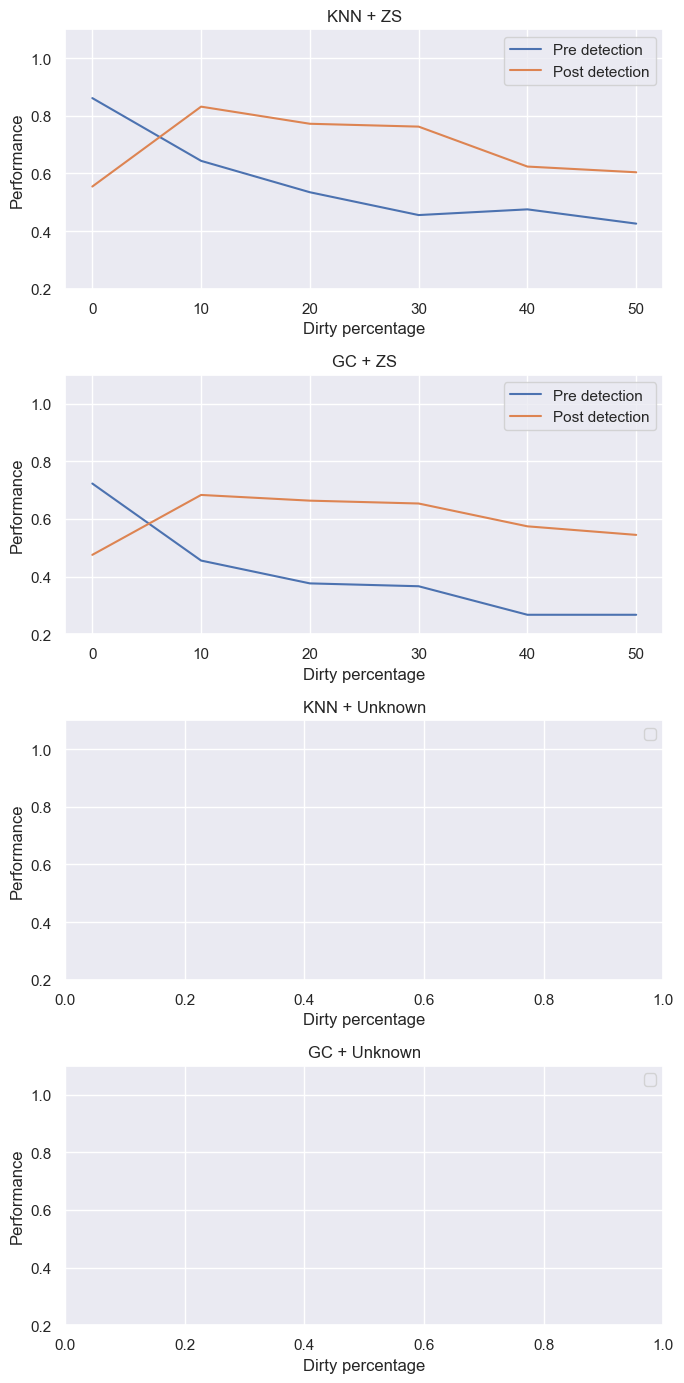

In [306]:
def toArray(score):
    t = []
    for s in score:
        t.append(s['scores'][1])
    return t
plotData = {
    'dirty': [0, 10, 20, 30, 40, 50],
    'knc_pre': toArray(knscores),
    'gc_pre': toArray(gcscore),
    'knc_zs_post': toArray(cleaned_knscores),
    'gc_zs_post': toArray(cleaned_gcscores)
}
plotDF = pd.DataFrame(plotData)
sns.set()
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(7,14))

sns.lineplot(ax=axes[0], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='knc_zs_post', data=plotDF)
axes[0].legend(['Pre detection', 'Post detection'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('KNN + ZS')

sns.lineplot(ax=axes[1], x='dirty', y='gc_pre', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
axes[1].legend(['Pre detection', 'Post detection'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('GC + ZS')

axes[2].legend(['Pre detection', 'Post detection'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('KNN + Unknown')

axes[3].legend(['Pre detection', 'Post detection'])
axes[3].set(xlabel='Dirty percentage', ylabel='Performance')
axes[3].set_ylim(0.2,1.1)
axes[3].set_title('GC + Unknown')
fig.tight_layout()

Text(0.5, 1.0, 'Post detection (Unknown) performances')

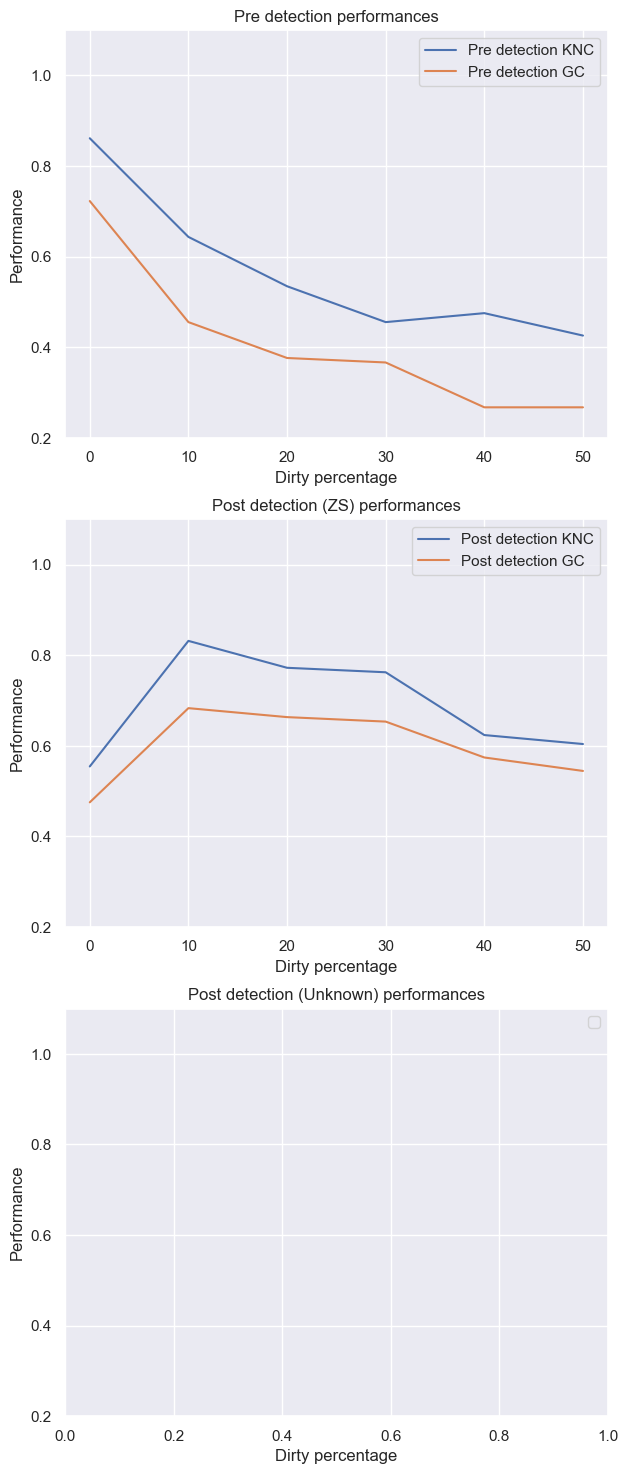

In [307]:
sns.set()
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='gc_pre', data=plotDF)
axes[0].legend(['Pre detection KNC', 'Pre detection GC'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('Pre detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='knc_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
axes[1].legend(['Post detection KNC', 'Post detection GC'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('Post detection (ZS) performances')

#sns.lineplot(ax=axes[2], x='dirty', y='', data=plotDF)
#sns.lineplot(ax=axes[2], x='dirty', y='', data=plotDF)
axes[2].legend(['Post detection KNC', 'Post detection GC'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('Post detection (Unknown) performances')